<a href="https://colab.research.google.com/github/wfreinhart/sdmm-regression/blob/main/notebooks/sequence_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# do the calculations

## load the sequences

In [ ]:
import numpy as np

all_sequences = np.loadtxt(f'all-sequences-60-40.txt', dtype=str)
all_sequences = np.array([[int(x) for x in s] for s in all_sequences])
print(all_sequences.shape)

(63090, 20)


## run the predictions

In [ ]:
import os
import torch


def predict_from_model(model, this_data):

    if 'MLP' in model.original_name:  # for MLP
        testX = torch.tensor(this_data, dtype=torch.float)
    elif 'CNN' in model.original_name:  # for CNN: 
        testX = torch.tensor(this_data, dtype=torch.float).unsqueeze(1)
    elif 'GRU' in model.original_name:  # for RNN: 
        testX = torch.tensor(this_data, dtype=torch.float).unsqueeze(2)

    pred_z_fwd = model(testX).detach().numpy()
    pred_z_rev = model(torch.fliplr(testX)).detach().numpy()
    pred_z = 0.5*(pred_z_fwd + pred_z_rev)

    return pred_z


drive_prefix = 'drive/Shareddrives/Polymers-Data'

predictions = []
model_path = os.path.join(drive_prefix, 'models', 'gru-opt-cv10-sym')
for i in range(10):
    model = torch.jit.load(os.path.join(model_path, f'fold-{i:02d}-scripted.pt'), map_location='cpu')
    model.eval()

    out = predict_from_model(model, all_sequences)
    predictions.append(out)

## setup functions

In [ ]:
!pip install levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 258 kB 7.7 MB/s 
     |████████████████████████████████| 1.8 MB 49.1 MB/s 
     |████████████████████████████████| 103 kB 48.2 MB/s 


In [ ]:
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.font_manager as font_manager
sc = 1.5
matplotlib.rcParams['font.family'] = 'Open Sans'  # the font name
matplotlib.rcParams['font.size'] = 9*sc           # the font size
font_manager._rebuild()  # this is a hack to fix something in Google Colab

In [ ]:
import Levenshtein


def str2int(s):
    AB = {'A': 0, 'B': 1}
    return [AB[it] for it in s]


def int2str(l):
    AB = 'AB'
    return ''.join([AB[it] for it in l])


def draw_comparison_seqs(target, ax=None, label_xaxis=True):
    diff = np.linalg.norm(all_sequences - str2int(target), axis=1)
    idx = np.argmin(diff)

    if diff[idx] != 0:
        diff = np.linalg.norm(all_sequences - str2int(target)[::-1], axis=1)
        idx = np.argmin(diff)

    if diff[idx] != 0:
        raise ValueError()

    mu = np.mean(predictions, axis=0)

    Zt = mu[idx]
    dZ = np.linalg.norm(mu - Zt, axis=1)

    # lev_dists = np.zeros(all_sequences.shape[0])
    # for i, s in enumerate(all_sequences):
    #     lev_dists[i] = Levenshtein.distance(target, int2str(s))

    lev_dists = np.zeros([all_sequences.shape[0], 2])
    for i, s in enumerate(all_sequences):
        lev_dists[i, 0] = Levenshtein.distance(target, int2str(s))
        lev_dists[i, 1] = Levenshtein.distance(target[::-1], int2str(s))
    
    lev_dists = np.min(lev_dists, axis=1)

    min_max = {}
    u = np.unique(lev_dists).astype(int)
    for ld in u:
        idx = np.argwhere(lev_dists == ld).flatten()
        min = idx[np.argmin(dZ[lev_dists == ld])]
        max = idx[np.argmax(dZ[lev_dists == ld])]
        if min != max:
            min_max[ld] = [min, max]

    LHS = [min_max[ld][0] for ld in sorted(min_max.keys())]
    RHS = [min_max[ld][1] for ld in sorted(min_max.keys())]

    sc = 1.5
    if ax is None:
        fig, ax = plt.subplots(figsize=(3.54*sc, 3.54*0.5*sc))

    ax.scatter(dZ[LHS], lev_dists[LHS], marker='<')#, c=sorted(min_max.keys()))
    ax.scatter(dZ[RHS], lev_dists[RHS], marker='>')#, c=sorted(min_max.keys()))

    xspace = 1.5
    ms = 18

    for offs, idx in [(np.min([dZ[i] for i in LHS])-21*xspace, LHS),
                    (np.max([dZ[i] for i in RHS])+2*xspace, RHS)]:
        for i in idx:
            # select fwd or rev:
            l_fwd = Levenshtein.distance(target, int2str(all_sequences[i]))
            l_rev = Levenshtein.distance(target, int2str(all_sequences[i][::-1]))
            if l_fwd <= l_rev:
                binseq = all_sequences[i]
            else:
                binseq = all_sequences[i][::-1]
            ax.scatter(np.arange(20)*xspace+offs,
                    np.zeros(20)+lev_dists[i],
                    c=binseq, s=ms*sc, cmap='Greys_r', linewidth=0.5,
                    marker='o', edgecolors='k')

    ax.text(np.max([dZ[i] for i in RHS])/2, -0.25, 'Target', ha='center')
    binseq = str2int(target)
    offs = np.min([dZ[i] for i in LHS])-21*xspace
    ax.scatter(np.arange(20)*xspace+offs,
            np.zeros(20), c=binseq, s=ms*sc, cmap='Greys_r',
            linewidth=0.5, marker='o', edgecolors='k')
    offs = np.max([dZ[i] for i in RHS])+2*xspace
    ax.scatter(np.arange(20)*xspace+offs,
            np.zeros(20), c=binseq, s=ms*sc, cmap='Greys_r',
            linewidth=0.5, marker='o', edgecolors='k')

    _ = ax.set_ylabel('Edit distance')
    if label_xaxis:
        _ = ax.set_xlabel('$|| \Delta \, \\tilde{Z} ||_2$')

    _ = ax.set_xticks(np.arange(0, np.max([dZ[i] for i in RHS]), 10))
    _ = ax.set_yticks(np.arange(0, np.max([lev_dists[i] for i in RHS]), 5))

    # ax.figure.tight_layout()

    return ax.figure

## load the MD runs

In [ ]:
import pandas as pd

exp_key = 'archetypes'
df = pd.read_csv(f'gru_{exp_key}_md.csv')
df

,Unnamed: 0,Sequence,Z0,Z1,Target_ID,Target_Z0,Target_Z1
0,329,BAAABABAABBAABAABABA,20.407690,2.235253,0,20.471924,2.369606
1,334,BAAABABAABBAABAABABA,20.486546,2.619609,0,20.471924,2.369606
2,339,BAAABABAABBAABAABABA,20.328863,1.951083,0,20.471924,2.369606
3,344,BAAABABAABBAABAABABA,20.117914,1.948951,0,20.471924,2.369606
4,349,BAAABABAABBAABAABABA,20.383142,2.698474,0,20.471924,2.369606
...,...,...,...,...,...,...,...
145,279,ABBBAABBAAAABBBAAAAA,-4.101957,0.206591,5,-4.627726,0.183026
146,284,ABBBAABBAAAABBBAAAAA,-3.829140,-0.317352,5,-4.627726,0.183026
147,289,ABBBAABBAAAABBBAAAAA,-4.050618,0.234654,5,-4.627726,0.183026
148,294,ABBBAABBAAAABBBAAAAA,-4.526780,0.381217,5,-4.627726,0.183026


In [ ]:
import numpy as np

# read off the targets
targets = []
for id in df['Target_ID'].unique():
    Z = df.loc[df['Target_ID'] == id, 'Target_Z0':'Target_Z1'].values[0]
    targets.append(Z)
print(targets)

# get the sequence that averaged closest to the target
sequences = []
for i, t in enumerate(targets):
    Z = df.loc[:, 'Target_Z0':'Target_Z1'].values

    seq_u = np.unique(df.loc[df['Target_ID']==i, 'Sequence'].values)

    avg_of_preds = np.zeros(len(seq_u))
    for k, seq in enumerate(seq_u):
        these_preds = df.loc[df['Sequence'] == seq, ['Z0', 'Z1', 'Target_ID']]
        avg_of_preds[k] = np.linalg.norm(t - these_preds.values[:, :2], axis=1).mean()
    
    b = np.argmin(avg_of_preds)
    sequences.append(seq_u[b])

print(sequences)

[array([20.471924,  2.369606]), array([1.214188, 9.048346]), array([ 2.774236, -4.223681]), array([-4.319901,  7.762145]), array([ 6.136077, 10.73103 ]), array([-4.627726,  0.183026])]
['BAAABABAABBAABAABABA', 'ABBAAAABAAAABBBBBAAA', 'BABBBBBABAABAAAAAAAA', 'ABABBABAAAAABBABBAAA', 'BBBAAABAABAAABBAABAA', 'ABBBAABBAAAABBBAAAAA']


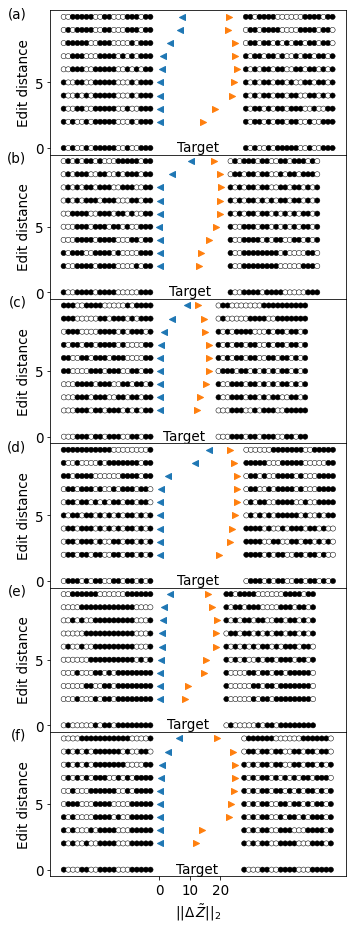

In [ ]:
# the order in the original 2021 paper:
# 0       1         2                  3       4                  5
# string, membrane, vesicle,           liquid, spherical micelle, wormlike micelle
# liquid, membrane, spherical micelle, string, vesicle,           wormlike micelle
# will use it like: arch_order[target_id]
# arch_order = [liquid, membrane, spherical micelle, string, vesicle, wormlike micelle]
arch_order = [3, 1, 4, 0, 2, 5]

N = len(df['Target_ID'].unique())
fig, axes = plt.subplots(N, 1, figsize=(3.54*sc, 3.54*0.5*sc*N),
                         sharex=True, gridspec_kw = {'wspace':0, 'hspace':0})

abc = 'abcdefghijkl'

for i in df['Target_ID'].unique():
    target = sequences[i]
    
    if exp_key == 'archetypes':
        k = arch_order[i]
    else:
        k = i
    ax = axes[k]
    
    fig = draw_comparison_seqs(target, ax=ax, label_xaxis=(i==(N-1)))

    ax.text(-0.08, 0.95, f'({abc[k]})', transform=ax.transAxes, ha='right')
    # fig.savefig(f'edit-{exp_key}-{k:02d}.pdf')

In [ ]:
fig.savefig(f'edit-{exp_key}-all.pdf', bbox_inches='tight')